# Clustering de datos

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
from functools import reduce

project_path = os.path.abspath('../..')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tslearn as ts

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KernelKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style="darkgrid")
sns.set_context('talk')

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data
from src.visualization.clustering import *
from src.models.clustering import bench_k_means

/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Torreo meteorológica de CODELCO

### Carga de datos 

In [48]:
def get_dates_with(df, col, level, condition='geq'):
    df_daily  = [g for n, g in df[col].groupby(pd.Grouper(freq='D')) if not g.empty]
    df_condition = []
    for df_day in df_daily:
        if (df_day > level).any():
            df_condition.append(df_day)
    return df_condition

quintero_df = get_minma_data(['SO2'], 'quintero', from_last='140w')
quintero_df = quintero_df.filter(regex='Registros no validados.*')

quintero_df = quintero_df.rename({'Registros no validados_SO2':'SO2'},axis=1)

asd =  get_dates_with(quintero_df, 'SO2', 130, 'geq')

In [177]:
df = pd.read_csv('quintero_peaks.csv', parse_dates=['date'], index_col=1).drop('Unnamed: 0', axis=1)

In [2]:
params = ['SO2','NO2', 'NO', 'NOX', 'O3', 'CO']
from_last = '5y'

In [4]:
data_df = get_minma_data(params, 'quintero', from_last=from_last)
data_df = data_df.filter(regex=("Registros no validados_"))
data_df.columns = data_df.columns.str.strip('Registros no validados_')
data_df.head()

/home/agonzalez/projects/mds7201-minma-so2/src/data/make_dataset.py:62: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  from_date = to_date - pd.Timedelta(from_last)


,SO2,NO2,NO,NOX,O3,CO
2017-09-06 18:00:00,2.76,2.96,2.05297,4.93210,25.0,0.25
2017-09-06 19:00:00,2.86,2.91,1.93715,4.77287,26.0,0.26
2017-09-06 20:00:00,3.17,3.72,2.11827,5.74518,26.0,0.27
2017-09-06 21:00:00,3.92,5.31,3.17362,8.35487,20.0,0.33
2017-09-06 22:00:00,12.87,10.46,5.06924,15.28560,7.0,0.46


In [5]:
df = data_df

In [6]:
df

,SO2,NO2,NO,NOX,O3,CO
2017-09-06 18:00:00,2.76,2.96,2.05297,4.93210,25.0,0.25
2017-09-06 19:00:00,2.86,2.91,1.93715,4.77287,26.0,0.26
2017-09-06 20:00:00,3.17,3.72,2.11827,5.74518,26.0,0.27
2017-09-06 21:00:00,3.92,5.31,3.17362,8.35487,20.0,0.33
2017-09-06 22:00:00,12.87,10.46,5.06924,15.28560,7.0,0.46
...,...,...,...,...,...,...
2022-09-06 19:00:00,2.21,6.98,1.35353,8.33331,36.0,0.35
2022-09-06 20:00:00,2.25,5.50,1.30148,6.80131,39.0,0.31
2022-09-06 21:00:00,2.27,4.48,1.19537,5.67241,39.0,0.32
2022-09-06 22:00:00,2.30,3.92,1.09673,5.01439,39.0,0.27


### Formateo para tslearn

In [7]:
meteo_daily = [g.diff() for n, g in df['SO2'].groupby(pd.Grouper(freq='D')) if not g.empty]

# meteo_daily_T = [g.values for n, g in meteo_df.loc['2017',['T_dif']].groupby(pd.Grouper(freq='D'))]
# meteo_daily_HR = [g.values for n, g in meteo_df.loc['2017',['HR_dif']].groupby(pd.Grouper(freq='D'))]

X_train = to_time_series_dataset(meteo_daily)
X_train = np.nan_to_num(X_train)

X_train, X_test = train_test_split(X_train,  test_size=0.30, random_state=42)

### Benchmarking con distinto n de clústers

In [8]:
seed = 42 
np.random.seed(seed)

dtw_inertia_list = []
gak_inertia_list = []
n_clusters = np.arange(2,10)

print('init\t\tn_clusters\ttime\tinertia\t\tsilhouette')
print(70 * '_')

for n in n_clusters:

    dtw_km = TimeSeriesKMeans(n_clusters=n,
                              n_init=5,
                              metric="dtw",
                              max_iter_barycenter=50,
                              random_state=seed)

    _, _, dtw_inertia = bench_k_means(kmeans=dtw_km, name="dtw", data=X_train, n_clusters=n)
    dtw_inertia_list.append(dtw_inertia)

    gak_km = KernelKMeans(n_clusters=n,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      random_state=seed)

    _, _, gak_inertia = bench_k_means(kmeans=gak_km, name="gak", data=X_train, n_clusters=n)
    gak_inertia_list.append(gak_inertia)

print(70 * '_')

init		n_clusters	time	inertia		silhouette
______________________________________________________________________
dtw      		2	63.357	8.748		0.019


KeyboardInterrupt: 

### Método del codo

#### DTW

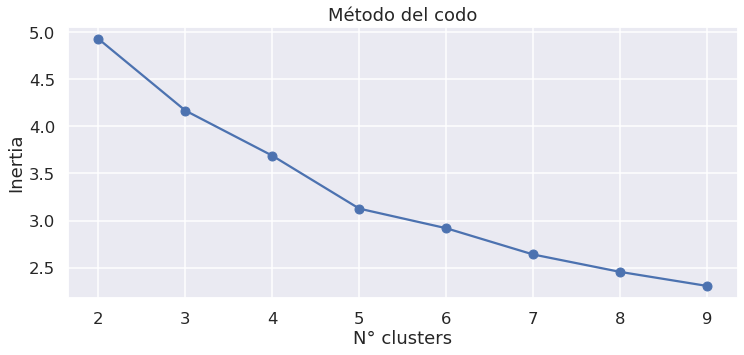

In [192]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(n_clusters, dtw_inertia_list, marker='o')
ax.set_title('Método del codo')
ax.set_xlabel('N° clusters')
ax.set_ylabel('Inertia')

plt.show()

#### GAK

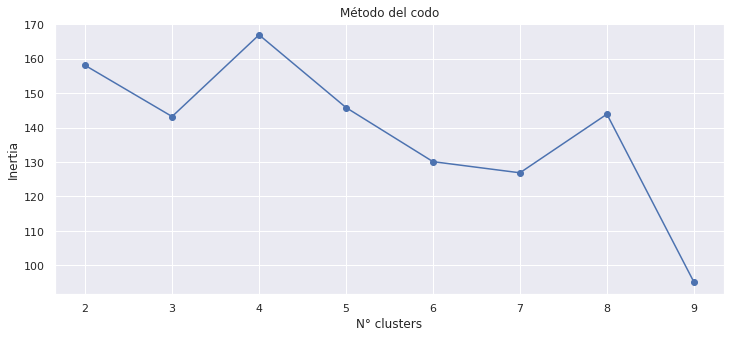

In [181]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(n_clusters, gak_inertia_list, marker='o')
ax.set_title('Método del codo')
ax.set_xlabel('N° clusters')
ax.set_ylabel('Inertia')

plt.show()

### Mejor modelo

In [13]:
seed = 42 
np.random.seed(seed)

dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=2,
                          metric="dtw",
                          max_iter_barycenter=10,
                          random_state=seed)

_, y_pred, _ = bench_k_means(kmeans=dba_km, name="dba_minmax", data=X_train, n_clusters=2)

dba_minmax		2	20.159	8.748		0.019


### Centros de clústers

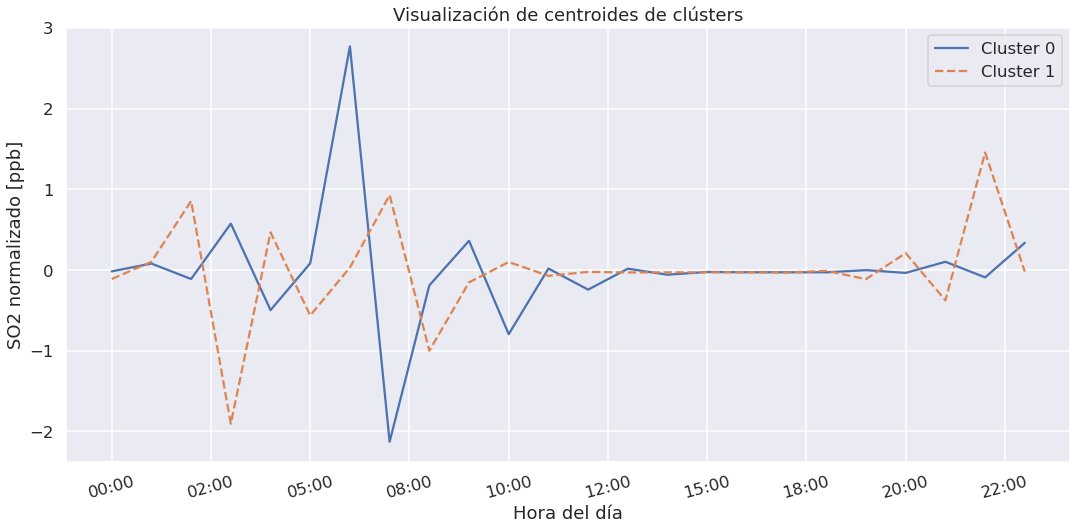

In [14]:
plot_cluster_centers(dba_km.cluster_centers_, ['Cluster 0','Cluster 1', 'Cluster 2','Cluster 3', 'Cluster 4'], "SO2 normalizado [ppb]")

### Distribución de clústers

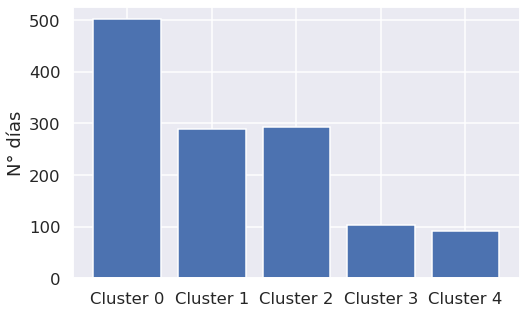

In [12]:
fig, axs = plt.subplots(figsize=(8,5))

cluster_distribution(y_pred)

plt.show()

### Visualización de clústers

IndexError: list index out of range

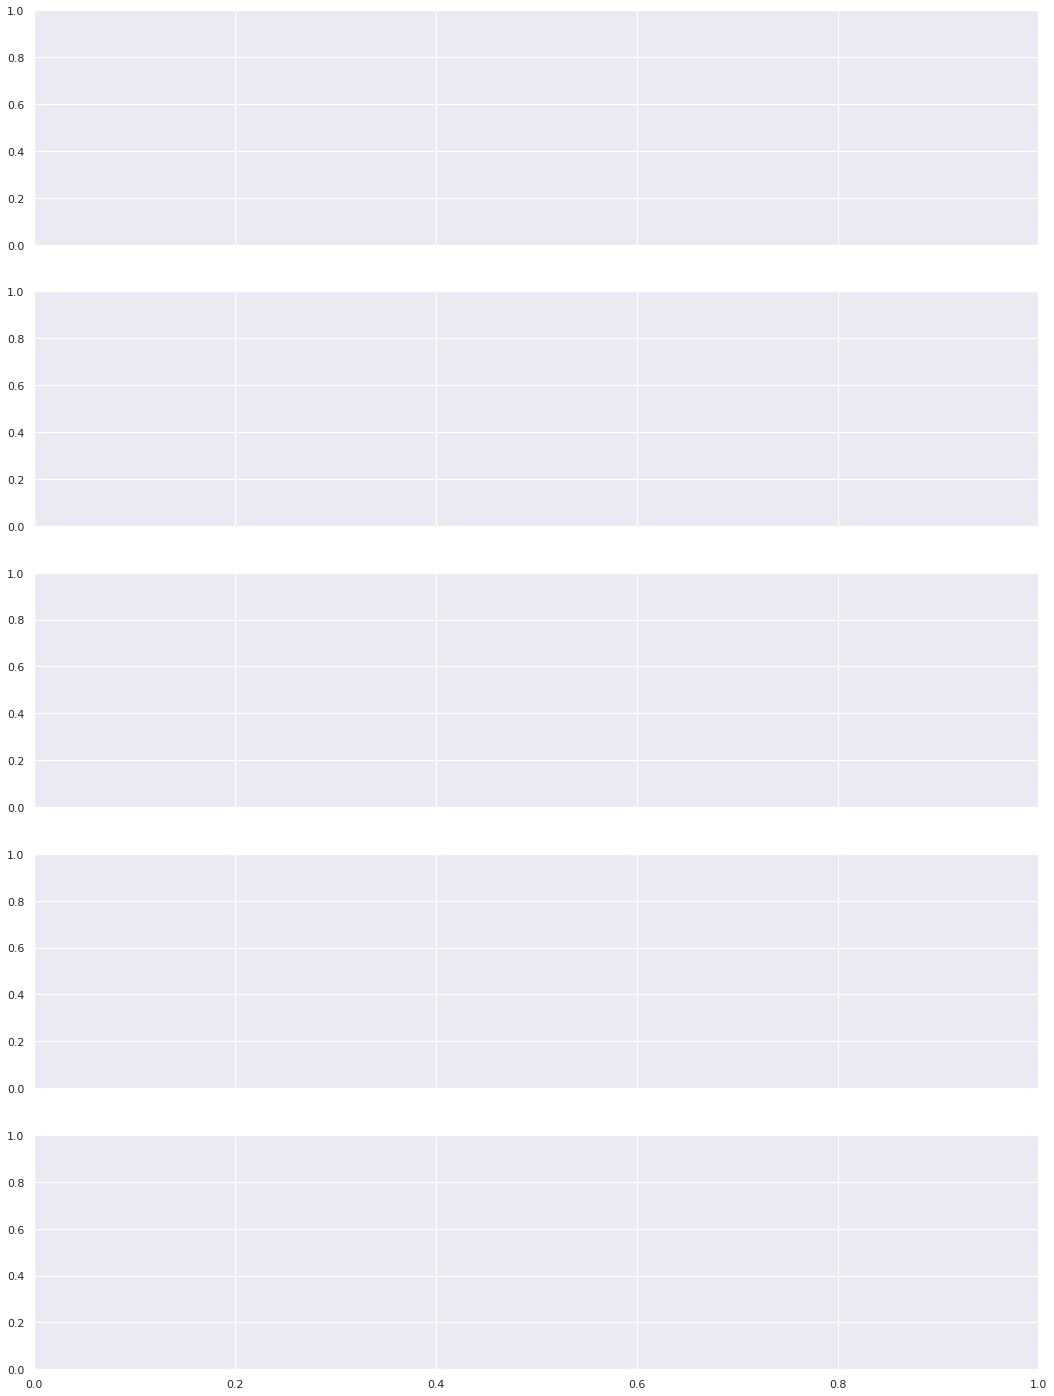

In [44]:
plot_series_by_cluster(y_pred, meteo_daily, dba_km.cluster_centers_, centers=True)

### Distribución semanal de clústers

In [25]:
weekly_cluster_distribution(y_pred, meteo_daily)

AttributeError: 'numpy.ndarray' object has no attribute 'index'